In [2]:
#!pip install -q transformers datasets torch
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12=

In [22]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer
from datasets import load_dataset
import wandb

import warnings
warnings.filterwarnings('ignore')

In [4]:
torch.cuda.is_available()

True

In [5]:
# Carrega o tokenizer e o dataset pré-definidos
tokenizer = AutoTokenizer.from_pretrained("muriloms/tcc-token-mini")
tokenized_dataset = load_dataset("muriloms/tcc-tokenized-dataset-mini")

tokenizer_config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/572 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [6]:
# Cria o DataCollator específico para LM causal (mlm=False)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [7]:
# Carrega o modelo base (por exemplo, GPT-2)
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
# Define os argumentos de treinamento
training_args = TrainingArguments(
    output_dir="my-llm-finetune",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,                     # Ajuste conforme necessário
    per_device_train_batch_size=2,          # Ajuste conforme a capacidade da GPU
    per_device_eval_batch_size=2,
    logging_steps=50,
    learning_rate=5e-5,                     # Ajuste conforme necessário
    weight_decay=0.01,
    fp16=True,                              # Ativa precisão mista se a GPU suportar
    push_to_hub=False
)

In [9]:
# Inicializa o Trainer com os datasets tokenizados e o data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator
)

In [10]:
# Desabilita o WandB (ou configure conforme sua preferência)
wandb.init(mode="disabled")

In [11]:
# Inicia o treinamento
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
1,0.319200,0.293384
2,0.278600,0.278339
3,0.255100,0.267429


TrainOutput(global_step=1200, training_loss=0.3380855488777161, metrics={'train_runtime': 67.4828, 'train_samples_per_second': 35.565, 'train_steps_per_second': 17.782, 'total_flos': 244961280000000.0, 'train_loss': 0.3380855488777161, 'epoch': 3.0})

In [12]:
eval_results = trainer.evaluate(tokenized_dataset["test"])
print(eval_results)

{'eval_loss': 0.2619432508945465, 'eval_runtime': 0.6936, 'eval_samples_per_second': 144.169, 'eval_steps_per_second': 72.085, 'epoch': 3.0}


In [51]:
#trainer.state.log_history

In [13]:
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.4M parameters


In [14]:
# Cálculo de métricas adicionais, por exemplo, Perplexity (se 'eval_loss' estiver presente)
if "eval_loss" in eval_results:
    perplexity = math.exp(eval_results["eval_loss"])
    print(f"Perplexity: {perplexity:.2f}")
    eval_results["perplexity"] = perplexity

Perplexity: 1.30


In [18]:
# Organiza os resultados em um DataFrame para facilitar comparações futuras
# Cada linha representará os resultados de um treinamento/modelo.
# Aqui, criamos um DataFrame com os resultados atuais:
current_run = {
    "model_name": model_name,
    "model_size_M": model_size / 1000**2,
    "eval_loss": eval_results.get("eval_loss", None),
    "perplexity": eval_results.get("perplexity", None),
    "num_train_epochs": training_args.num_train_epochs,
    "batch_size": training_args.per_device_train_batch_size,
    "learning_rate": training_args.learning_rate
}

In [19]:
results_df = pd.DataFrame([current_run])
print("\nEvaluation Summary Table:")
results_df


Evaluation Summary Table:


,model_name,model_size_M,eval_loss,perplexity,num_train_epochs,batch_size,learning_rate
0,gpt2,124.439808,0.261943,1.299453,3,2,0.00005


In [20]:
# Salva os resultados atuais em um arquivo CSV para comparação futura
# Caso você já tenha um arquivo com resultados anteriores, pode carregá-lo e concatenar.
results_csv = "model_evaluation_results.csv"
try:
    existing_df = pd.read_csv(results_csv)
    combined_df = pd.concat([existing_df, results_df], ignore_index=True)
except FileNotFoundError:
    combined_df = results_df

combined_df.to_csv(results_csv, index=False)
print(f"Results saved to {results_csv}")

Results saved to model_evaluation_results.csv


Text(0.5, 0, 'Model Name')

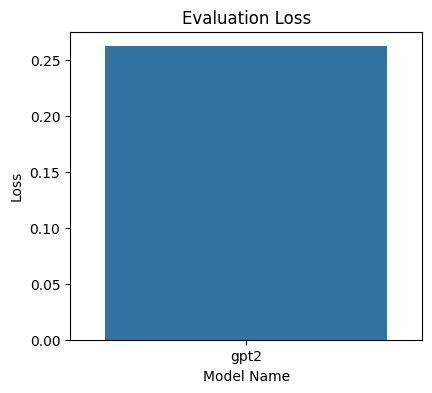

In [23]:
# Exemplo de gráfico comparando a perda de avaliação e perplexidade dos modelos
# Caso haja múltiplos modelos avaliados, a coluna "model_name" pode ser utilizada para a comparação.
plt.figure(figsize=(10, 4))

# Gráfico da Loss
plt.subplot(1, 2, 1)
sns.barplot(x="model_name", y="eval_loss", data=combined_df)
plt.title("Evaluation Loss")
plt.ylabel("Loss")
plt.xlabel("Model Name")

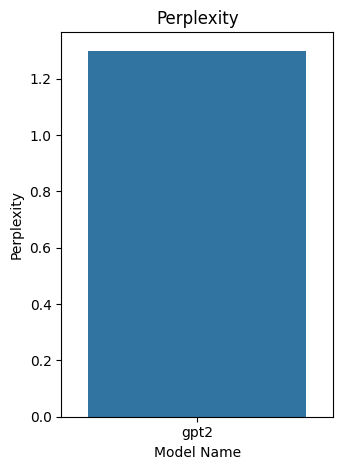

In [24]:
# Gráfico da Perplexity
plt.subplot(1, 2, 2)
sns.barplot(x="model_name", y="perplexity", data=combined_df)
plt.title("Perplexity")
plt.ylabel("Perplexity")
plt.xlabel("Model Name")

plt.tight_layout()
plt.show()

# Fine-tuning de diversos modelos

In [28]:
# Lista de modelos a serem fine-tuned
model_names = [
    "gpt2",
    "distilgpt2"
]

In [34]:
# Carrega o dataset
dataset = load_dataset("muriloms/tcc-dataset-mini")

README.md:   0%|          | 0.00/524 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/73.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [53]:
def extract_epoch_metrics(trainer):
    """
    A partir do trainer.state.log_history, extrai os logs que contêm o valor de loss e a
    informação de epoch. Em seguida, agrupa os logs por época (utilizando a função ceil para
    transformar frações de época no respectivo número inteiro) e calcula a média da loss em cada época.

    Retorna um DataFrame com as colunas:
      - epoch: a época (inteiro)
      - training_loss: média da loss registrada naquela época
    """
    logs = trainer.state.log_history  # lista de dicionários
    # Converte a lista em um DataFrame
    df_logs = pd.DataFrame(logs)
    # Filtra as entradas que possuem loss registrada
    df_logs = df_logs[df_logs["loss"].notnull()].copy()
    # Cria uma coluna "epoch_group": arredonda a época para o inteiro superior
    df_logs["epoch_group"] = df_logs["epoch"].apply(lambda x: math.ceil(x))
    # Agrupa por epoch e calcula a média da loss para cada grupo
    epoch_metrics = df_logs.groupby("epoch_group")["loss"].mean().reset_index()
    # Renomeia as colunas para maior clareza
    epoch_metrics = epoch_metrics.rename(columns={"epoch_group": "epoch", "loss": "training_loss"})
    return epoch_metrics

In [31]:
# Define o comprimento máximo das sequências tokenizadas
max_seq_length = 200

In [36]:
def preprocess_function(examples, tokenizer):
    """
    Concatena os campos 'history' e 'action_label' para formar um único texto de entrada,
    tokeniza o texto aplicando truncamento e padding para um comprimento fixo, e replica os input_ids
    em labels para a tarefa de modelagem de linguagem causal.
    """
    texts = [f"{history}\nNextAction: {label}"
             for history, label in zip(examples["history"], examples["action_label"])]

    model_inputs = tokenizer(
        texts,
        max_length=max_seq_length,
        truncation=True,
        padding="max_length",  # Para padronizar o comprimento das sequências
        return_attention_mask=True
    )

    model_inputs["labels"] = model_inputs["input_ids"].copy()
    return model_inputs

In [38]:
# Função para realizar o fine-tuning para um modelo específico
def fine_tune_model(model_name):
    print(f"\nFine-tuning model: {model_name}\n{'=' * 60}")

    # Carrega o tokenizer e, se necessário, define o token de padding
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Carrega o modelo para LM causal
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Tokeniza o dataset utilizando a função de pré-processamento, que é aplicada em modo batched
    tokenized_dataset = dataset.map(
        lambda examples: preprocess_function(examples, tokenizer),
        batched=True,
        remove_columns=["history", "action_label"],
        load_from_cache_file=True
    )

    # Cria o data collator adequado para a LM causal
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

    # Define os parâmetros de treinamento
    output_dir = f"finetune_{model_name.replace('/', '_')}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=3,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        logging_steps=50,
        learning_rate=5e-5,
        weight_decay=0.01,
        fp16=True,  # Utilize FP16 se sua GPU oferecer suporte a precisão mista
        push_to_hub=False,
        save_total_limit=2
    )

    # Cria o Trainer e inicia o treinamento
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        data_collator=data_collator
    )

    trainer.train()
    #trainer.save_model(os.path.join(output_dir, "final_model"))
    print("Salvar no Hugging Face")
    trainer.push_to_hub(f"tcc-finetune_{model_name.replace('/', '_')}")

    # Retorna o trainer e o modelo treinado, caso você deseje fazer avaliações adicionais
    return trainer, model

In [39]:
from huggingface_hub import notebook_login
notebook_login()

In [54]:
# Realiza o fine-tuning para cada modelo da lista
results = {}
model_epoch_results = {}
for m_name in model_names:
    trainer, model = fine_tune_model(m_name)
    results[m_name] = trainer.evaluate(tokenized_dataset["test"])
    print(f"Evaluation results for {m_name}: {results[m_name]}\n{'-' * 60}")

    epoch_df = extract_epoch_metrics(trainer)
    model_epoch_results[m_name] = epoch_df


Fine-tuning model: gpt2


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.319200,0.293384
2,0.278600,0.278339
3,0.255100,0.267429


events.out.tfevents.1738525241.d72073a58d20.3839.7:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

events.out.tfevents.1738523998.d72073a58d20.3839.4:   0%|          | 0.00/359 [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Evaluation results for gpt2: {'eval_loss': 0.2619432508945465, 'eval_runtime': 0.7211, 'eval_samples_per_second': 138.676, 'eval_steps_per_second': 69.338, 'epoch': 3.0}
------------------------------------------------------------

Fine-tuning model: distilgpt2


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss
1,0.340500,0.308325
2,0.296800,0.294785
3,0.273400,0.284051


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1738524053.d72073a58d20.3839.6:   0%|          | 0.00/359 [00:00<?, ?B/s]

events.out.tfevents.1738525316.d72073a58d20.3839.9:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Evaluation results for distilgpt2: {'eval_loss': 0.27941209077835083, 'eval_runtime': 0.4482, 'eval_samples_per_second': 223.131, 'eval_steps_per_second': 111.565, 'epoch': 3.0}
------------------------------------------------------------


In [41]:
results

{'gpt2': {'eval_loss': 0.2619432508945465,
  'eval_runtime': 0.7,
  'eval_samples_per_second': 142.857,
  'eval_steps_per_second': 71.429,
  'epoch': 3.0},
 'distilgpt2': {'eval_loss': 0.27941209077835083,
  'eval_runtime': 0.4556,
  'eval_samples_per_second': 219.511,
  'eval_steps_per_second': 109.756,
  'epoch': 3.0}}

In [45]:
# Calcular a perplexity e organizar os dados em uma lista de dicionários
data = []
for model_name, metrics in results.items():
    loss = metrics.get("eval_loss", None)
    # A perplexity é definida como a exponenciação da loss, assumindo que a loss é calculada como log-loss
    perplexity = math.exp(loss) if loss is not None else None
    data.append({
        "model_name": model_name,
        "eval_loss": loss,
        "perplexity": perplexity
    })

In [46]:
# Criar um DataFrame com os resultados
results_df = pd.DataFrame(data)
print("Evaluation Results Summary:")
results_df

Evaluation Results Summary:


,model_name,eval_loss,perplexity
0,gpt2,0.261943,1.299453
1,distilgpt2,0.279412,1.322352


([0, 1], [Text(0, 0, 'gpt2'), Text(1, 0, 'distilgpt2')])

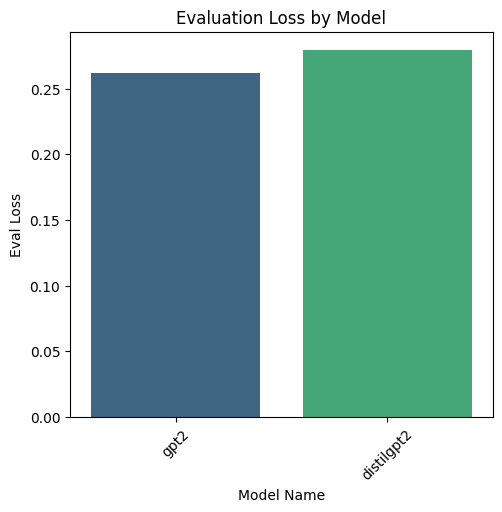

In [47]:
# Gerar gráficos comparativos para Loss e Perplexity
plt.figure(figsize=(12, 5))

# Gráfico de barras para Evaluation Loss
plt.subplot(1, 2, 1)
sns.barplot(x="model_name", y="eval_loss", data=results_df, palette="viridis")
plt.title("Evaluation Loss by Model")
plt.xlabel("Model Name")
plt.ylabel("Eval Loss")
plt.xticks(rotation=45)

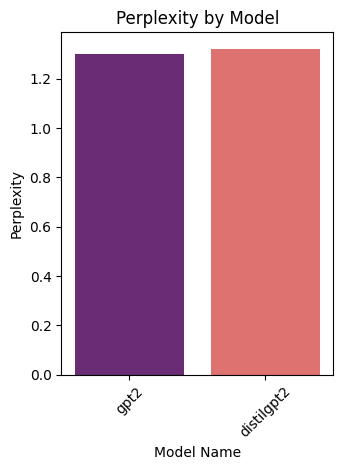

In [48]:
# Gráfico de barras para Perplexity
plt.subplot(1, 2, 2)
sns.barplot(x="model_name", y="perplexity", data=results_df, palette="magma")
plt.title("Perplexity by Model")
plt.xlabel("Model Name")
plt.ylabel("Perplexity")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [55]:
# Converte os resultados em uma lista de DataFrames e adiciona uma coluna 'model'
all_results_training_loss = []
for model_name, df_epoch in model_epoch_results.items():
    df_epoch["model"] = model_name
    all_results_training_loss.append(df_epoch)

In [56]:
# Concatena todos os DataFrames em um único DataFrame
all_results_training_loss_df = pd.concat(all_results_training_loss, ignore_index=True)
print("Combined Epoch Metrics:")
all_results_training_loss_df

Combined Epoch Metrics:


,epoch,training_loss,model
0,1,0.456925,gpt2
1,2,0.289050,gpt2
2,3,0.268288,gpt2
3,1,0.492200,distilgpt2
4,2,0.310400,distilgpt2
5,3,0.289237,distilgpt2


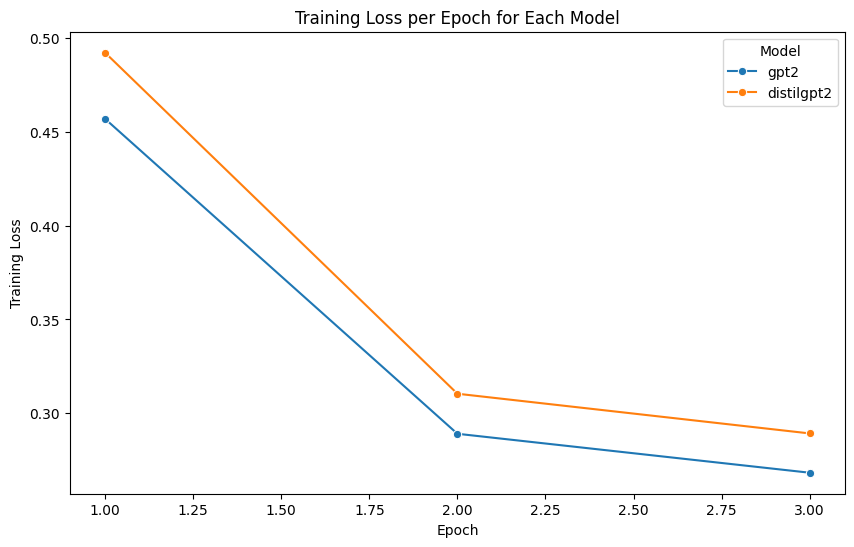

In [58]:
# Geração dos gráficos comparativos
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_results_training_loss_df, x="epoch", y="training_loss", hue="model", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch for Each Model")
plt.legend(title="Model", loc="upper right")
plt.show()

# Connect to Hugging Face

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer.push_to_hub("tcc-mba-v1-gpt-2-mini")

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

events.out.tfevents.1738183518.f68c3e036f8a.9539.1:   0%|          | 0.00/359 [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

events.out.tfevents.1738181601.f68c3e036f8a.2537.0:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

events.out.tfevents.1738183047.f68c3e036f8a.9539.0:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/muriloms/my-llm-finetune/commit/24688f4b43064f6152356bf5c2f5c687388c8b35', commit_message='tcc-mba-v1-gpt-2-mini', commit_description='', oid='24688f4b43064f6152356bf5c2f5c687388c8b35', pr_url=None, repo_url=RepoUrl('https://huggingface.co/muriloms/my-llm-finetune', endpoint='https://huggingface.co', repo_type='model', repo_id='muriloms/my-llm-finetune'), pr_revision=None, pr_num=None)

# Use Model

In [18]:
import torch
from transformers import pipeline

In [19]:
pipe = pipeline(
    "text-generation",
    model=model_name,
    tokenizer=tokenizer
)

Device set to use cuda:0


In [20]:
# Define the prompt template
prompt_template = """\
You are a model specialized in predicting the next action in a soccer match.
You will be given a detailed description of a current match situation (the "context").
Your task is to provide only the next action or play, without repeating the context,
without explaining any reasoning, and without adding extra details.

Context:
{match_context}

Question:
What is the next play in one concise sentence?
"""

In [21]:
# Example context (this is what you change in each call)
context_text = "At minute 12:30, Forward John Doe from Team X at coordinates (70, 30) performed a Dribble."

In [22]:
# Construct the final prompt
final_prompt = prompt_template.format(match_context=context_text)

In [23]:
# Run the generation
result = pipe(
    final_prompt,
    max_new_tokens=50,   # Limit the response length
    num_return_sequences=1,
    do_sample=True       # Depending on if you want sampling or greedy
)

In [24]:
# Extract the generated text
generated_text = result[0]["generated_text"]

print("=== MODEL OUTPUT ===")
print(generated_text)
print("====================")

=== MODEL OUTPUT ===
You are a model specialized in predicting the next action in a soccer match.
You will be given a detailed description of a current match situation (the "context").
Your task is to provide only the next action or play, without repeating the context,
without explaining any reasoning, and without adding extra details.

Context:
At minute 12:30, Forward John Doe from Team X at coordinates (70, 30) performed a Dribble.

Question:
What is the next play in one concise sentence?

Answer:

Forward John Doe from Team Y at coordinates (68, 30) performed a Dribble.

Question:

What type of strike was the last strike used by Team Y? For example, was the strike the
